<a href="https://colab.research.google.com/github/Junhojuno/keras-tutorial/blob/master/03_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [8]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print("train data shape : {}, test data shape : {}".format(train_data.shape, test_data.shape))

train data shape : (404, 13), test data shape : (102, 13)


In [9]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [0]:
# 정규화 ;  normalization
# 모든 feature의 값을 평균은 0, 표준편차는 1로 맞춰준다.
test_data = (test_data - train_data.mean(axis=0)) / train_data.std(axis=0)
train_data = (train_data - train_data.mean(axis=0)) / train_data.std(axis=0)

In [0]:
# model function 생성
# 동일한 모델을 여러번 생성할 거라 함수로 만들어준다.
# 샘플이 적기 때문에 64 units, 2 hidden-layers 구성
def build_model():
    model = models.Sequential()
    # 13 = train_shape[1]
    model.add(Dense(64, input_shape=(13,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [13]:
# k fold cross validation
import numpy as np
k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    model.fit(x=partial_train_data, y=partial_train_targets, epochs=num_epochs, batch_size=1)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Epoch 1/100
303/303 [==============================] - 2s 5ms/step - loss: 218.8428 - mean_absolute_error: 11.3046
Epoch 2/100
303/303 [==============================] - 1s 4ms/step - loss: 29.8314 - mean_absolute_error: 3.7437
Epoch 3/100
303/303 [==============================] - 1s 4ms/step - loss: 21.6371 - mean_absolute_error: 3.2225
Epoch 4/100
303/303 [==============================] - 1s 4ms/step - loss: 18.3232 - mean_absolute_error: 2.9223
Epoch 5/100
303/303 [==============================] - 1s 4ms/step - loss: 16.2920 - mean_absolute_error: 2.7821
Epoch 6/100
303/303 [==============================] - 1s 4ms/step - loss: 14.6928 - mean_absolute_error: 2.6040
Epoch 7/100
303/303 [==============================] - 1s 4ms/step - loss: 14.4841 - mean_absolute_error: 2.4948
Epoch 8/100
303/303 [==============================] - 1s 4ms/step - loss: 13.7456 - mean_absolute_error: 2.4910
Epoch 9/100
303/303 [==============================] - 1s 4ms/step - loss: 12.6465 - mean_abso

In [14]:
print(all_scores)
print(np.mean(all_scores))

[1.903231651476114, 2.7658244170764887, 2.402047894968845, 2.7243980564693415]
2.4488755049976976


validation score가 2.04~2.9까지 폭이 크다. <br>
각각의 validation score보다 평균값이 더 신뢰할만한하다

In [0]:
# validation score를 로그에 저장하기
# epoch를 500으로 늘려 차이를 확인하자
k = 4

all_mae_histories = []

num_val_samples = len(train_data) // k
num_epochs = 500

for i in range(k):
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    hist = model.fit(x=partial_train_data, y=partial_train_targets,
                     epochs=num_epochs, batch_size=1, verbose=0, 
                     validation_data=(val_data, val_targets))
    mae_history = hist.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [0]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] 

<function matplotlib.pyplot.show>

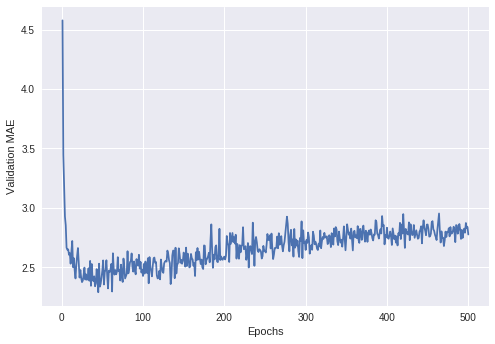

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show

<function matplotlib.pyplot.show>

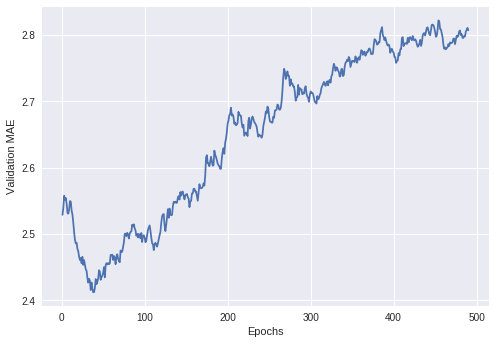

In [25]:
# 첫 데이터 10개 제거
# exponential moving average 적용
# 결과적으로 부드럽게 올라가는 곡선을 만들어보자
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  
  # smoothed_points가 채워져있으면(if)~비워져있으면(else)
  for point in points:
    if smoothed_points :
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + (1-factor) * point)
      
    else:
      smoothed_points.append(point)
      
  return smoothed_points

# 처음 10개의 값은 빼준다.
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show

40 epoch정도부터 error가 증가하는 것으로 보아, 이때부터 overfitting된것으로 보인다.

In [26]:
# 새로 모델 compile
model = build_model()
model.fit(x=train_data, y=train_targets, epochs=40, batch_size=16, verbose=0)
test_mse, test_mae = model.evaluate(x=test_data, y=test_targets)
test_mae

102/102 [==============================] - 0s 4ms/step


2.9837855638242234

2,983 달러 정도 차이가 난다.